<a href="https://colab.research.google.com/github/2303A52189/PROJECTS/blob/main/rl_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📤 Upload an image file (JPG/PNG):


Saving object.jpg to object.jpg
✅ Image uploaded successfully: object.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


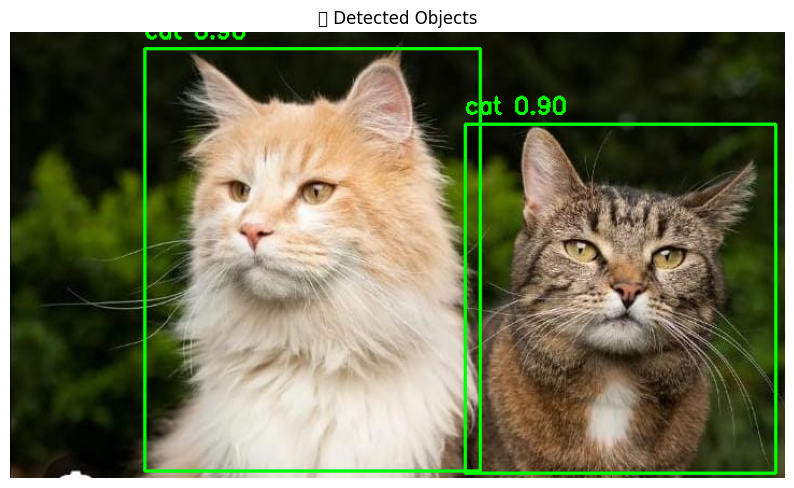


Detected objects with confidence:
  • cat: 0.90
  • cat: 0.90

🔊 Spoken Text: Detected objects are: cat


In [ ]:
# Step 0: Install required libraries
!pip install -q ultralytics gtts IPython

# Step 1: Import necessary libraries
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from ultralytics import YOLO
from gtts import gTTS
import IPython.display as ipd

# Step 2: Upload an image
print("📤 Upload an image file (JPG/PNG):")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print("✅ Image uploaded successfully:", image_path)

# Step 3: Load YOLOv8 model (use medium for better accuracy)
# You can use yolov8m.pt (medium) or yolov8l.pt (large)
model = YOLO("yolov8m.pt")

# Step 4: Perform object detection
CONF_THRESHOLD = 0.65   # Higher = more accurate, fewer false detections
IOU_THRESHOLD = 0.45
IMG_SIZE = 640

results = model.predict(
    source=image_path,
    conf=CONF_THRESHOLD,
    iou=IOU_THRESHOLD,
    imgsz=IMG_SIZE,
    max_det=100,
    verbose=False
)

# Step 5: Read the image with OpenCV
image = cv2.imread(image_path)
if image is None:
    raise RuntimeError("❌ Could not load image. Check file format.")
orig = image.copy()

# Step 6: Extract detections
res = results[0]
detected = []
for box in res.boxes:
    xyxy = box.xyxy[0].cpu().numpy().astype(int).tolist()  # [x1,y1,x2,y2]
    conf = float(box.conf[0].cpu().numpy().tolist())
    cls_id = int(box.cls[0].cpu().numpy().tolist())
    label = model.names.get(cls_id, str(cls_id))
    detected.append((label, conf, xyxy))

# Step 7: Filter detections (ignore false positives like low-confidence "person")
filtered = []
for label, conf, xyxy in detected:
    # Ignore low-confidence persons
    if label == "person" and conf < 0.8:
        continue
    filtered.append((label, conf, xyxy))

# Step 8: Draw bounding boxes and labels
for label, conf, (x1, y1, x2, y2) in filtered:
    cv2.rectangle(orig, (x1, y1), (x2, y2), (0, 255, 0), 2)
    text = f"{label} {conf:.2f}"
    cv2.putText(orig, text, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Step 9: Display detected image
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("✅ Detected Objects")
plt.show()

# Step 10: Print detections in console
if filtered:
    print("\nDetected objects with confidence:")
    for label, conf, _ in filtered:
        print(f"  • {label}: {conf:.2f}")
else:
    print("⚠️ No confident detections found.")

# Step 11: Convert detections to audio
unique_labels = sorted(set([label for label, _, _ in filtered]))
if unique_labels:
    text_to_speak = "Detected objects are: " + ", ".join(unique_labels)
    print("\n🔊 Spoken Text:", text_to_speak)
    tts = gTTS(text_to_speak, lang="en")
    tts.save("detected_objects.mp3")
    ipd.display(ipd.Audio("detected_objects.mp3", autoplay=True))
else:
    print("\n🔇 No high-confidence objects to announce.")
